Goal: The goal for this competition is to predict whether an applicant is approved for a loan.


https://www.kaggle.com/competitions/playground-series-s4e10/overview



Columns:


id: A unique identifier for each record in the dataset.

person_age: The age of the borrower, which can help assess loan default risk.

person_income: The borrower's personal income, used to evaluate their repayment ability.

person_home_ownership: The type of home ownership the borrower has, such as renting or owning, which may impact loan risk.

person_emp_length: The length of time the borrower has been employed, which reflects job stability.

loan_intent: The purpose of the loan, like for education, medical expenses, or debt consolidation.

loan_grade: A rating that shows the borrower’s creditworthiness, with grades ranging from high to low risk.

loan_amnt: The amount of money the borrower is requesting for the loan.

loan_int_rate: The interest rate applied to the loan, influencing the total repayment amount.

loan_percent_income: The percentage of the borrower’s income that will go toward loan repayment.

cb_person_default_on_file: Indicates whether the borrower has a history of defaulting on credit ("Y" for yes, "N" for no).

cb_person_cred_hist_length: The number of years of the borrower's credit history.

**loan_status: Indicates the current status of the loan, such as whether it is paid, in default, or active.**




Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import files

Importing files

In [ ]:
test = pd.read_csv('https://drive.google.com/uc?id=1pKKkRr_YMAfoWJzi5LFy-wBzbrDx6XmZ')
train = pd.read_csv('https://drive.google.com/uc?id=1sOezdtSDlUQCaoe8w8n8Rqg4V-A7TWV0')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [ ]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [ ]:
train['loan_status'].unique()

array([0, 1])

In [ ]:
train['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [ ]:
train['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [ ]:
train['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [ ]:
train['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
# Mapping for 'person_home_ownership'
ownership_mapping = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}

# Mapping for 'loan_intent'
intent_mapping = {'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3,
                  'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}

# Mapping for 'loan_grade'
grade_mapping = {'B': 0, 'C': 1, 'A': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

# Apply the mappings to the corresponding columns
train['person_home_ownership'] = train['person_home_ownership'].map(ownership_mapping)
train['loan_intent'] = train['loan_intent'].map(intent_mapping)
train['loan_grade'] = train['loan_grade'].map(grade_mapping)

# Also for test dataset
test['person_home_ownership'] = test['person_home_ownership'].map(ownership_mapping)
test['loan_intent'] = test['loan_intent'].map(intent_mapping)
test['loan_grade'] = test['loan_grade'].map(grade_mapping)

In [ ]:
# Mapping boolean values
boolean_mapping = {'N': 0, 'Y': 1}
train.cb_person_default_on_file = train.cb_person_default_on_file.map(boolean_mapping)
train[['cb_person_default_on_file', 'loan_status']] = train[['cb_person_default_on_file', 'loan_status']].astype('boolean')

# Also for test dataset
test.cb_person_default_on_file = test.cb_person_default_on_file.map(boolean_mapping)
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].astype('boolean')

<Axes: >

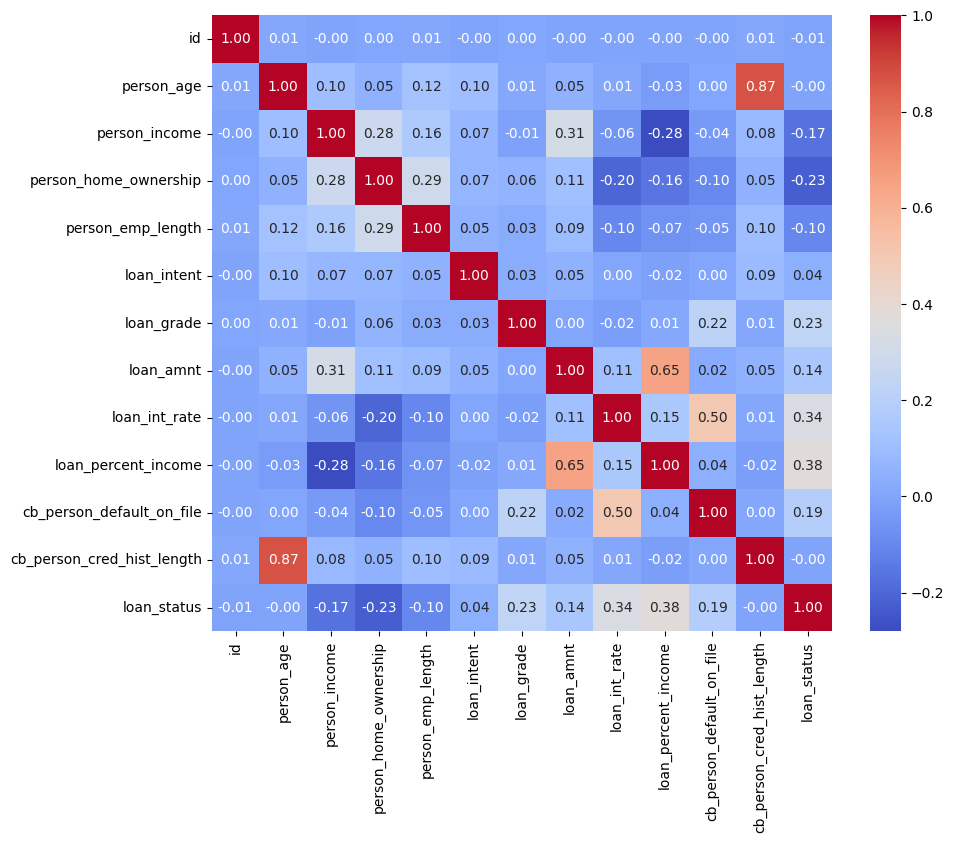

In [ ]:
# Correlation heatmap (numeric cols only)
plt.figure(figsize=(10,8))
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot= True, fmt='.2f',cmap='coolwarm')

In [ ]:
# Splitting data
X = train.drop('loan_status', axis=1)
y = train['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'eta': 0.5,
    'eval_metric': 'logloss'
}

num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10)

# Predictions
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

[0]	test-logloss:0.25092
[1]	test-logloss:0.21167
[2]	test-logloss:0.19219
[3]	test-logloss:0.18071
[4]	test-logloss:0.17478
[5]	test-logloss:0.17063
[6]	test-logloss:0.16773
[7]	test-logloss:0.16655
[8]	test-logloss:0.16181
[9]	test-logloss:0.16135
[10]	test-logloss:0.16075
[11]	test-logloss:0.15861
[12]	test-logloss:0.15791
[13]	test-logloss:0.15592
[14]	test-logloss:0.15570
[15]	test-logloss:0.15512
[16]	test-logloss:0.15462
[17]	test-logloss:0.15434
[18]	test-logloss:0.15201
[19]	test-logloss:0.15199
[20]	test-logloss:0.15087
[21]	test-logloss:0.15030
[22]	test-logloss:0.15019
[23]	test-logloss:0.15020
[24]	test-logloss:0.15021
[25]	test-logloss:0.15004
[26]	test-logloss:0.15024
[27]	test-logloss:0.15036
[28]	test-logloss:0.15010
[29]	test-logloss:0.15021
[30]	test-logloss:0.15037
[31]	test-logloss:0.15037
[32]	test-logloss:0.15035
[33]	test-logloss:0.15020
[34]	test-logloss:0.15030
Accuracy: 0.9539


In [ ]:
# DMatrix
dtest_final = xgb.DMatrix(test)

# Prediction
y_pred_prob_final = bst.predict(dtest_final)
y_pred_final = [1 if prob > 0.5 else 0 for prob in y_pred_prob_final]

if not isinstance(test, pd.DataFrame):
    test = pd.DataFrame(test)

# Adding the predictions as a new column 'loan_status'
test['loan_status'] = y_pred_final

# Saving output as csvs
submission = test[['id', 'loan_status']]
submission.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>